# **Introduction to CUDA**

This lab gives a brief introduction to CUDA GPU computing platform, we will revisit the GPU basic architecture and recall some of cuda terminology: threads, blocks, grid and kernel. Then we'll define the program execution lifecycle. Finally we'll delve into some program examples, gradually leverage execution parallelism and highlight some CUDA key concepts.

 ### **Recall: GPU Architecure**
 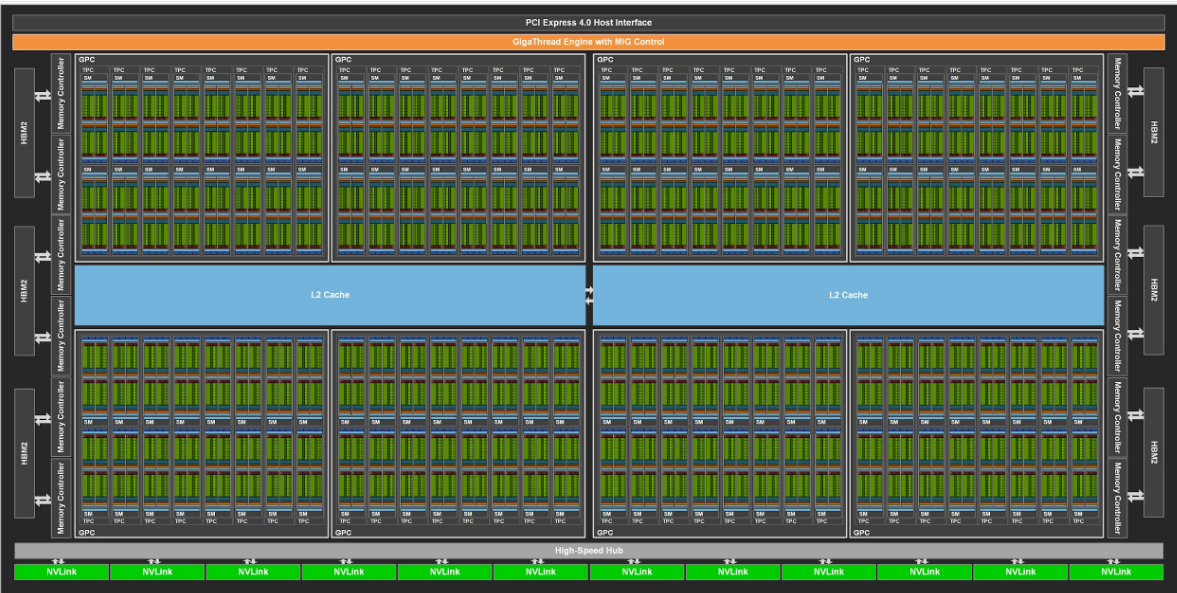

### **Recall: Cuda semantics**
Block:  

*   Multi-dimensional array of threads 1D, 2D, or 3D
*   Threads in a block can synchronize among themselves.
*   Threads in a block can access shared memory.

Grid:  

*   Multi-dimensional array of blocks 1D or 2D
*   Blocks in a grid can run in parallel, or sequentially.


*Mapping Threads, blocks, grid to GPU components*

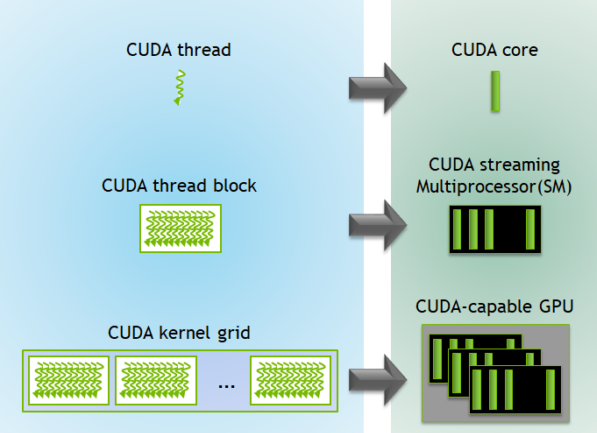



### **Kernels**

A GPU kernel is a piece of code that is executed in parallel by multiple threads on an accelerator such as a GPU. These kernels are designed to handle highly parallelizable tasks that take advantage of the many cores present in modern GPUs. Kernel execution is issued in grid units
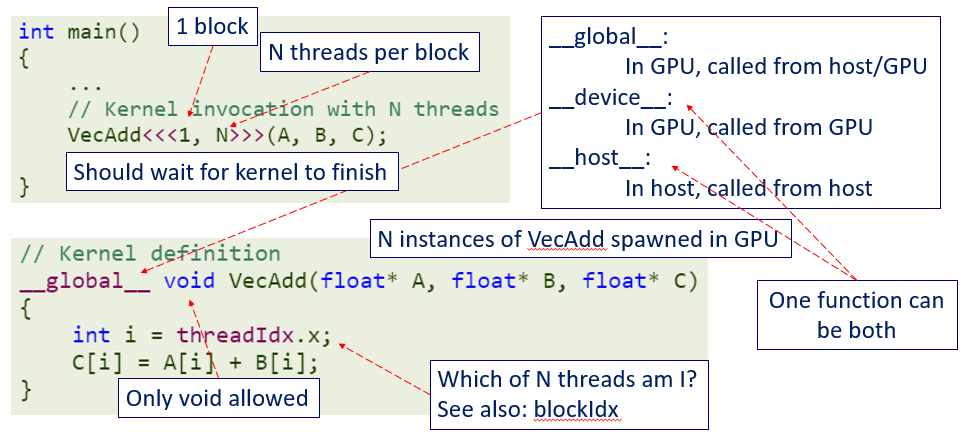

### **Thread, block indexing**

For convenience, **threadIdx** is a 3-component vector, so that threads can be identified using a one-dimensional, two-dimensional, or three-dimensional thread index, forming a one-dimensional, two-dimensional, or three-dimensional block of threads, called a thread block. This provides a natural way to invoke computation across the elements in a domain such as a vector, matrix, or volume.

The index of a thread and its thread ID relate to each other in a straightforward way: For a one-dimensional block, they are the same; for a two-dimensional block of size (Dx, Dy), the thread ID of a thread of index (x, y) is (x + y Dx); for a three-dimensional block of size (Dx, Dy, Dz), the thread ID of a thread of index (x, y, z) is (x + y Dx + z Dx Dy).

Each block within the grid can be identified by a one-dimensional, two-dimensional, or three-dimensional unique index accessible within the kernel through the built-in **blockIdx** variable. The dimension of the thread block is accessible within the kernel through the built-in **blockDim** variable.

### **Program lifecycle**



1.  Allocate host memory and initialize host data
2.  Allocate device memory
3.  Transfer input data from host to device memory
4.  Execute kernels
5.  Transfer output from device memory to host



### **Examples**

In [1]:
# Setup cuda environment
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ztg42d_9
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ztg42d_9
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 781ff5b76ba6c4c2d80dcbbec9983e147613cc71
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.1.0-py3-none-any.whl size=8011 sha256=e2b2acbb79d726227ace2ffdeb18b901e4debb9cf9419b13a35a389a655ee4ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-lg2su6dz/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmpihftsz1g".


1- *Vector Addition*

In [7]:
# Vector addition in pure C (CPU-only execution)

%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <assert.h>

#define N 10000000
#define MAX_ERR 1e-6

void vector_add(float *out, float *a, float *b, int n) {
    for(int i = 0; i < n; i++){
        out[i] = a[i] + b[i];
    }
}

int main(){
    float *a, *b, *out;

    // Allocate memory
    a   = (float*)malloc(sizeof(float) * N);
    b   = (float*)malloc(sizeof(float) * N);
    out = (float*)malloc(sizeof(float) * N);

    // Initialize array
    for(int i = 0; i < N; i++){
        a[i] = 1.0f;
        b[i] = 2.0f;
    }

    // Main function
    vector_add(out, a, b, N);

    // Verification
    for(int i = 0; i < N; i++){
        assert(fabs(out[i] - a[i] - b[i]) < MAX_ERR);
    }
}

In [16]:
# Vector addition in CUDA (Kernel1: No parallelism)

%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <assert.h>
#include <cuda.h>
#include <cuda_runtime.h>

#define N 10000000
#define MAX_ERR 1e-6
__global__ void vector_add(float *out, float *a, float *b, int n) {
    for(int i = 0; i < n; i ++){
        out[i] = a[i] + b[i];
    }
}
int main(){
    float *a, *b, *out;
    float *d_a, *d_b, *d_out;

    // Allocate host memory
    a   = (float*)malloc(sizeof(float) * N);
    b   = (float*)malloc(sizeof(float) * N);
    out = (float*)malloc(sizeof(float) * N);

    // Initialize host arrays
    for(int i = 0; i < N; i++){
        a[i] = 1.0f;
        b[i] = 2.0f;
    }

    // Allocate device memory
    cudaMalloc((void**)&d_a, sizeof(float) * N);
    cudaMalloc((void**)&d_b, sizeof(float) * N);
    cudaMalloc((void**)&d_out, sizeof(float) * N);

    // Transfer data from host to device memory
    cudaMemcpy(d_a, a, sizeof(float) * N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, sizeof(float) * N, cudaMemcpyHostToDevice);

    // Executing kernel (1block, 1thread: no parallelism)
    vector_add<<<1,1>>>(d_out, d_a, d_b, N);

    // Transfer data back to host memory
    cudaMemcpy(out, d_out, sizeof(float) * N, cudaMemcpyDeviceToHost);

    // Verification
    for(int i = 0; i < N; i++){
        assert(fabs(out[i] - a[i] - b[i]) < MAX_ERR);
    }
    printf("out[0] = %f\n", out[0]);
    printf("PASSED\n");

    // Deallocate device memory
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_out);

    // Deallocate host memory
    free(a);
    free(b);
    free(out);
}

out[0] = 3.000000
PASSED



### **Profiling performance**


Using time does not give much information about the program performance. NVIDIA provides a commandline profiler tool called nvprof, which give a more insight information of CUDA program performance.

To profile our vector addition, use following command:

In [2]:
!nvcc kernel1.cu -o kernel1
!nvprof ./kernel1

==710== NVPROF is profiling process 710, command: ./kernel1
out[0] = 3.000000
PASSED
==710== Profiling application: ./kernel1
==710== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   92.69%  659.27ms         1  659.27ms  659.27ms  659.27ms  vector_add(float*, float*, float*, int)
                    4.99%  35.477ms         1  35.477ms  35.477ms  35.477ms  [CUDA memcpy DtoH]
                    2.32%  16.506ms         2  8.2529ms  8.2433ms  8.2624ms  [CUDA memcpy HtoD]
      API calls:   68.03%  713.08ms         3  237.69ms  8.4490ms  696.17ms  cudaMemcpy
                   20.67%  216.63ms         3  72.209ms  112.87us  216.39ms  cudaMalloc
                   11.05%  115.80ms         1  115.80ms  115.80ms  115.80ms  cudaLaunchKernel
                    0.24%  2.4720ms         3  823.99us  302.21us  1.0968ms  cudaFree
                    0.02%  162.30us       114  1.4230us     148ns  56.960us  cuDeviceGetAttribute
   

*Back to Vector Addition*

In [19]:
# Vector addition in CUDA (Kernel2: level1 parallelism-> 1block, multiple threads)
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <assert.h>
#define N 10000000
#define MAX_ERR 1e-6
__global__ void vector_add(float *out, float *a, float *b, int n) {
    int index = threadIdx.x;
    int stride = blockDim.x;

    for(int i = index; i < n; i += stride){
        out[i] = a[i] + b[i];
    }
}
// What else to change?
// Executing kernel
// vector_add<<<1,256>>>(d_out, d_a, d_b, N);
int main(){
    float *a, *b, *out;
    float *d_a, *d_b, *d_out;

    // Allocate host memory
    a   = (float*)malloc(sizeof(float) * N);
    b   = (float*)malloc(sizeof(float) * N);
    out = (float*)malloc(sizeof(float) * N);

    // Initialize host arrays
    for(int i = 0; i < N; i++){
        a[i] = 1.0f;
        b[i] = 2.0f;
    }

    // Allocate device memory
    cudaMalloc((void**)&d_a, sizeof(float) * N);
    cudaMalloc((void**)&d_b, sizeof(float) * N);
    cudaMalloc((void**)&d_out, sizeof(float) * N);

    // Transfer data from host to device memory
    cudaMemcpy(d_a, a, sizeof(float) * N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, sizeof(float) * N, cudaMemcpyHostToDevice);

    // Executing kernel (1block, 1thread: no parallelism)
    vector_add<<<1,256>>>(d_out, d_a, d_b, N);

    // Transfer data back to host memory
    cudaMemcpy(out, d_out, sizeof(float) * N, cudaMemcpyDeviceToHost);

    // Verification
    for(int i = 0; i < N; i++){
        assert(fabs(out[i] - a[i] - b[i]) < MAX_ERR);
    }
    printf("out[0] = %f\n", out[0]);
    printf("PASSED\n");

    // Deallocate device memory
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_out);

    // Deallocate host memory
    free(a);
    free(b);
    free(out);
}

out[0] = 3.000000
PASSED



In [3]:
!nvcc kernel2.cu -o kernel2
!nvprof ./kernel2

==1150== NVPROF is profiling process 1150, command: ./kernel2
out[0] = 3.000000
PASSED
==1150== Profiling application: ./kernel2
==1150== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   39.95%  27.549ms         1  27.549ms  27.549ms  27.549ms  [CUDA memcpy DtoH]
                   33.22%  22.903ms         1  22.903ms  22.903ms  22.903ms  vector_add(float*, float*, float*, int)
                   26.83%  18.500ms         2  9.2502ms  8.9117ms  9.5888ms  [CUDA memcpy HtoD]
      API calls:   59.88%  175.09ms         3  58.364ms  112.82us  174.86ms  cudaMalloc
                   24.03%  70.259ms         3  23.420ms  9.1664ms  51.272ms  cudaMemcpy
                   15.23%  44.523ms         1  44.523ms  44.523ms  44.523ms  cudaLaunchKernel
                    0.81%  2.3746ms         3  791.55us  200.99us  1.1088ms  cudaFree
                    0.05%  152.23us       114  1.3350us     145ns  64.491us  cuDeviceGetAttribute

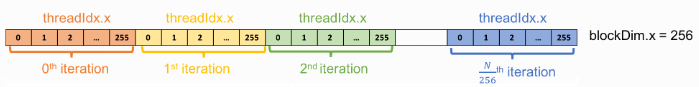

In [6]:
# Vector addition in CUDA (Kernel3: level2 parallelism-> multiple blocks, each with multiple threads)
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <assert.h>
#define N 10000000
#define MAX_ERR 1e-6
__global__ void vector_add(float *out, float *a, float *b, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;

    // Handling arbitrary vector size
    if (tid < n){
        out[tid] = a[tid] + b[tid];
    }
}

// Executing kernel
// int block_size = 256;
// int grid_size = ((N + block_size) / block_size);
// vector_add<<<grid_size,block_size>>>(d_out, d_a, d_b, N);
int main(){
    float *a, *b, *out;
    float *d_a, *d_b, *d_out;

    // Allocate host memory
    a   = (float*)malloc(sizeof(float) * N);
    b   = (float*)malloc(sizeof(float) * N);
    out = (float*)malloc(sizeof(float) * N);

    // Initialize host arrays
    for(int i = 0; i < N; i++){
        a[i] = 1.0f;
        b[i] = 2.0f;
    }

    // Allocate device memory
    cudaMalloc((void**)&d_a, sizeof(float) * N);
    cudaMalloc((void**)&d_b, sizeof(float) * N);
    cudaMalloc((void**)&d_out, sizeof(float) * N);

    // Transfer data from host to device memory
    cudaMemcpy(d_a, a, sizeof(float) * N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, sizeof(float) * N, cudaMemcpyHostToDevice);

    int block_size = 256;
    int grid_size = ((N + block_size) / block_size);
    vector_add<<<grid_size,block_size>>>(d_out, d_a, d_b, N);

    // Transfer data back to host memory
    cudaMemcpy(out, d_out, sizeof(float) * N, cudaMemcpyDeviceToHost);

    // Verification
    for(int i = 0; i < N; i++){
        assert(fabs(out[i] - a[i] - b[i]) < MAX_ERR);
    }
    printf("out[0] = %f\n", out[0]);
    printf("PASSED\n");

    // Deallocate device memory
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_out);

    // Deallocate host memory
    free(a);
    free(b);
    free(out);
}

out[0] = 3.000000
PASSED



In [4]:
!nvcc kernel3.cu -o kernel3
!nvprof ./kernel3

==1378== NVPROF is profiling process 1378, command: ./kernel3
out[0] = 3.000000
PASSED
==1378== Profiling application: ./kernel3
==1378== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   60.30%  27.634ms         1  27.634ms  27.634ms  27.634ms  [CUDA memcpy DtoH]
                   38.70%  17.735ms         2  8.8677ms  8.4890ms  9.2464ms  [CUDA memcpy HtoD]
                    1.01%  461.34us         1  461.34us  461.34us  461.34us  vector_add(float*, float*, float*, int)
      API calls:   68.35%  188.09ms         3  62.696ms  189.82us  187.65ms  cudaMalloc
                   17.15%  47.211ms         3  15.737ms  8.7508ms  29.003ms  cudaMemcpy
                   13.56%  37.322ms         1  37.322ms  37.322ms  37.322ms  cudaLaunchKernel
                    0.87%  2.3944ms         3  798.15us  219.49us  1.1103ms  cudaFree
                    0.06%  163.41us       114  1.4330us     138ns  64.803us  cuDeviceGetAttribute

2- *Matrix Addition*

In [ ]:
# Level1 parallelism (1block, multiple threads)
// Kernel definition
__global__ void MatAdd(float A[N][N], float B[N][N],
                       float C[N][N])
{
    int i = threadIdx.x;
    int j = threadIdx.y;
    C[i][j] = A[i][j] + B[i][j];
}

int main()
{
    ...
    // Kernel invocation with one block of N * N * 1 threads
    int numBlocks = 1;
    dim3 threadsPerBlock(N, N);
    MatAdd<<<numBlocks, threadsPerBlock>>>(A, B, C);
    ...
}

In [ ]:
# Level2 parallelism (multiple blocks, each with multiple threads)
// Kernel definition
__global__ void MatAdd(float A[N][N], float B[N][N],
float C[N][N])
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i < N && j < N)
        C[i][j] = A[i][j] + B[i][j];
}

int main()
{
    ...
    // Kernel invocation
    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks(N / threadsPerBlock.x, N / threadsPerBlock.y);
    MatAdd<<<numBlocks, threadsPerBlock>>>(A, B, C);
    ...
}

### **Resource Balancing**

A thread block size of 16x16 (256 threads) is a common choice, however

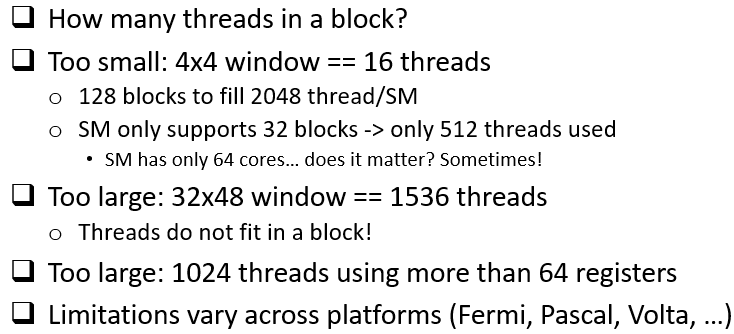

There is a limit to the number of threads per block, since all threads of a block are expected to reside on the same streaming multiprocessor core and must share the limited memory resources of that core. On current GPUs, a thread block may contain up to 1024 threads.

### **Thread Synchronization**

Threads within a block can cooperate by sharing data through some shared memory and by synchronizing their execution to coordinate memory accesses. More precisely, one can specify synchronization points in the kernel by calling the __syncthreads() intrinsic function; __syncthreads() acts as a barrier at which all threads in the block must wait before any is allowed to proceed

In [ ]:
# __syncthreads() example

__shared__ float partialSum[SIZE];
partialSum[threadIdx.x] = X[blockIdx.x * blockDim.x + threadIdx.x];
unsigned int t = threadIdx.x;
for(unsigned int stride = 1; stride < blockDim.x; stride *= 2){
     __syncthreads();
     if(t % (2*stride) == 0)
          partialSum[t] += partialSum[t+stride];
}

In [ ]:
# Does this code work properly? why?
if{
     ...
     __syncthreads();
}else{
     ...
     __syncthreads();
}

### **Requirement 2**

1) Complete the provided matrix addition example, following these cases:
        
        A.   kernel1: each thread produces one output matrix element
        B.   kernel2: each thread produces one output matrix row
        C.   kernel3: each thread produces one output matrix column
  Analyze the pros and cons of each of the kernels above by using nvprof with large matrix sizes to validate your points. Collect your insights in a PDF report and explain them.

2) Implement a matrix–vector multiplication kernel. Use one thread to calculate an output vector element.

Let both programs read testcases from a .txt file and print the output to another. Their pathes are to be provided as command line arguments. Sample test file and invoking command are to be attached to the e-learning page.



### **Resources**


*   https://docs.nvidia.com/cuda/cuda-c-programming-guide/indexhtml#programming-model
*   https://cuda-tutorial.readthedocs.io/en/latest/tutorials/tutorial01/
*   https://nichijou.co/cuda4-sync/

